In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../mio/features")
sys.path.append("../mio/utilities/")
sys.path.append("../mio/utilities/summarystats")
sys.path.append("../mio/data")
sys.path.append("../mio/designs")

from mio.visualize import interactive_scatter
from mio.data.dataset import DataSet
from gillespy2.solvers.cpp import SSACSolver
from gillespy2.solvers.stochkit import StochKitSolver
import gillespy2
import numpy as np

In [4]:
import gillespy2
class ToggleSwitch(gillespy2.Model):
    """ Gardner et al. Nature (1999)
    'Construction of a genetic toggle switch in Escherichia coli'
    """
    def __init__(self, parameter_values=None):
        # Initialize the model.
        gillespy2.Model.__init__(self, name="toggle_switch")
        # Parameters
        alpha1 = gillespy2.Parameter(name='alpha1', expression=1)
        alpha2 = gillespy2.Parameter(name='alpha2', expression=1)
        beta = gillespy2.Parameter(name='beta', expression="2.0")
        gamma = gillespy2.Parameter(name='gamma', expression="2.0")
        mu = gillespy2.Parameter(name='mu', expression=1.0)
        self.add_parameter([alpha1, alpha2, beta, gamma, mu])

        # Species
        U = gillespy2.Species(name='U', initial_value=10)
        V = gillespy2.Species(name='V', initial_value=10)
        self.add_species([U, V])

        # Reactions
        cu = gillespy2.Reaction(name="r1",reactants={}, products={U:1},
                propensity_function="alpha1/(1+pow(V,beta))")
        cv = gillespy2.Reaction(name="r2",reactants={}, products={V:1},
                propensity_function="alpha2/(1+pow(U,gamma))")
        du = gillespy2.Reaction(name="r3",reactants={U:1}, products={},
                rate=mu)
        dv = gillespy2.Reaction(name="r4",reactants={V:1}, products={},
                rate=mu)
        self.add_reaction([cu,cv,du,dv])
        self.timespan(np.linspace(0,100,101))

In [5]:
model = ToggleSwitch()

In [23]:
def set_model_parameters(model, params):
    """ params - array, needs to have the same order as model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# model need be passed as argument for distributed comp.
def simulator(model, params):
    
    tot_res = []
    
    for p in params:
        model = set_model_parameters(model, p)
        num_trajectories = 1
        res = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=num_trajectories)
        tot_res.append(res[0][:,1:]) #should not contain timepoints
    
    return np.array(tot_res)
    
    

In [7]:
from summary_base import SummaryBase
from feature_extraction import generate_tsfresh_features
from tsfresh.feature_extraction import MinimalFCParameters


# Class definition: SummariesEnsemble
class SummariesTSFRESH(SummaryBase):
    """
    An ensemble of different statistics from TSFRESH
    """

    def __init__(self):
        self.name = 'SummariesTSFRESH'
        self.features = None
        super(SummariesTSFRESH, self).__init__(self.name)

    def compute(self, data, features=MinimalFCParameters()):
        self.features = features
        feature_values = generate_tsfresh_features(data, features)
        # ToDo: Check for NaNs
        return feature_values


In [31]:
from mio.designs.random_sampling import RandomSampling

default_param = np.array(list(model.listOfParameters.items()))[:,1]
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    
bound = np.array(bound)

sampler = RandomSampling(xmax=bound*10, xmin=bound*0.1)

In [53]:
f = SummariesTSFRESH()
data = DataSet(name='tsfresh')

data.configurations['listOfParameters'] = list(model.listOfParameters.keys())
data.configurations['listOfSpecies'] = list(model.listOfSpecies.keys())
data.configurations['listOfSummaries'] = MinimalFCParameters()
data.configurations['timepoints'] = model.tspan

In [69]:
# Sample some random points and simulate
X = sampler.generate(50)
res = simulator(model, X)
print(res.shape)

(50, 101, 2)


In [70]:
featuresU = f.compute(res[:,:,0])
featuresV = f.compute(res[:,:,1])
features  = []
for i in range(len(featuresU)):
    features.append(np.concatenate((featuresU[i], featuresV[i])))

features = np.array(features)
print(features.shape)

(50, 16)


In [71]:
# Add data to DataSet instance
labels = np.ones(len(res))*-1
data.add_points(inputs=X, targets=labels, time_series=res, summary_stats=features) 

In [72]:
import umap
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dr_data = scaler.fit_transform(data.s)

dr = umap.UMAP(n_components=2, n_neighbors=5, min_dist=0.2)
dr_data = dr.fit_transform(dr_data)

<IPython.core.display.Javascript object>


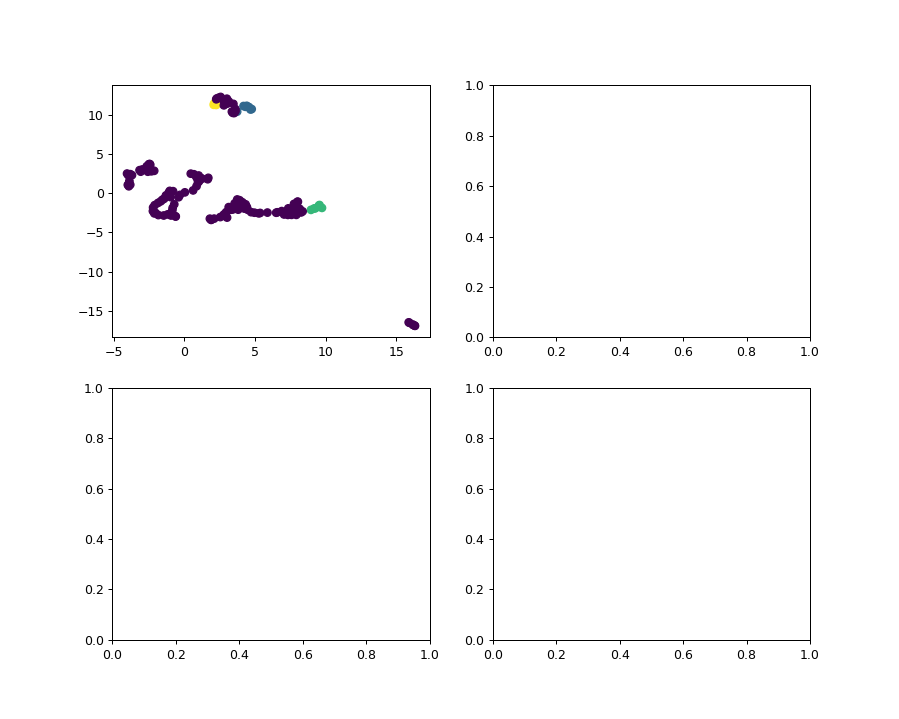

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'U': 0, 'V': 1}, value=0)

Dropdown(description='Species plot 2', index=1, options={'U': 0, 'V': 1}, value=1)

,alpha1,alpha2,beta,gamma,mu
0,1.415483,9.639901,12.440181,14.129776,2.791937
1,3.084472,4.080089,7.448996,17.768465,2.965045
2,5.846859,8.460081,7.513008,15.151928,7.458531
3,0.245972,0.382834,19.563735,7.015906,4.638429
4,8.221588,8.407948,5.395899,16.051011,7.730748
5,5.806979,1.999240,16.567106,1.790747,2.019457
6,5.026017,2.417418,11.757065,8.413084,7.830798
7,3.580014,0.146131,11.409072,9.678989,9.296719
8,3.607965,3.742352,9.741111,11.511680,6.040050
9,1.479333,7.945271,17.642829,6.523228,0.138828


In [73]:
interactive_scatter.interative_scatter(scatter_data=dr_data, data_class=data)